In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cglb import load_snelson_data, plot_prediction
from pathlib import Path
from gpflow.models import CGLB, SGPR, GPR
from gpflow.kernels import SquaredExponential
from gpflow.optimizers import Scipy

2022-03-16 12:26:15.121258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 12:26:15.121284: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline

First, we load the `snelson1d` training dataset.

In [3]:
data = load_snelson_data()

The CGLB model introduces less bias in comparison to SGPR model.
We can show empirically that CGLB has a lower bias by plotting the objective landscape with respect to different values of the lengthscale hyperparameters.

2022-03-16 12:26:17.524597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 12:26:17.524623: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 12:26:17.524642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d3a3da1576a3): /proc/driver/nvidia/version does not exist
2022-03-16 12:26:17.524891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 12:26:17.586258: W tensorflow/python/util/util.cc:348] Sets are not currently considered se

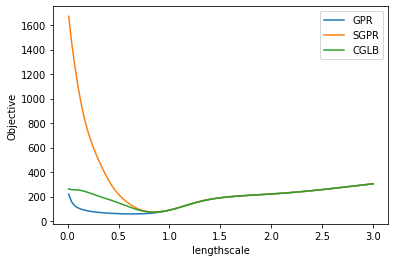

In [4]:

x, y = data
n = x.shape[0]
m = 10

iv_indices = np.random.choice(range(n), size=m, replace=False)
iv = x[iv_indices, :]

noise = 0.1
gpr = GPR(data, kernel=SquaredExponential(), noise_variance=noise)
cglb = CGLB(data, kernel=SquaredExponential(), noise_variance=noise, inducing_variable=iv)
sgpr = SGPR(data, kernel=SquaredExponential(), noise_variance=noise, inducing_variable=iv)


def loss_with_changed_parameter(model, parameter, value: float):
    original = parameter.numpy()
    parameter.assign(value)
    loss = model.training_loss()
    parameter.assign(original)
    return loss.numpy()


ls = np.linspace(0.01, 3, 100)
losses_fn = lambda m: [loss_with_changed_parameter(m, m.kernel.lengthscales, l) for l in ls]
gpr_obj = losses_fn(gpr)
sgpr_obj = losses_fn(sgpr)
cglb_obj = losses_fn(cglb)

plt.plot(ls, gpr_obj, label="GPR")
plt.plot(ls, sgpr_obj, label="SGPR")
plt.plot(ls, cglb_obj, label="CGLB")
plt.xlabel("lengthscale")
plt.ylabel("Objective")
plt.legend()
plt.show()

The interface of CGLB model is similar to SGPR, however, it has extra options related to the conjugate gradient which is involved in the computation of $ yᵀK⁻¹y $.
* `cg_tolerance`. This is the expected maximum error in the solution produced by the conjugate gradient,
i.e. the ϵ threshold of the stopping criteria in the CG loop: $ rᵀQ⁻¹r < 0.5ϵ $.
The default value for `cg_tolerance` is $ 1.0 $. It is a good working value for model training, which has been confirmed in practice. The `predict_f`, `predict_log_density`, and `predict_y` methods have their own `cg_tolerance` options as for predictions you might want to tighten up the CG solution closer to exact.
* `max_cg_iters`. The maximum number of CG iterations.
* `restart_cg_step`. The frequency with wich the CG resets the internal state to the initial position using current solution vector `v`.
* `v_grad_optimization`. CGLB introduces auxiliary parameter `v`, and by default optimal `v` is found with the CG. However you can include `v` into the list of trainable model parameters.

In [5]:

cglb = CGLB(
    data,
    kernel=SquaredExponential(),
    noise_variance=noise,
    inducing_variable=iv,
    cg_tolerance=1.0,
    max_cg_iters=50,
    restart_cg_iters=50,
)
opt = Scipy()

We train the model as usual. Variables do not include the $ v $ auxiliary vector.

In [6]:
variables = cglb.trainable_variables
_ = opt.minimize(
    cglb.training_loss_closure(compile=False), variables, compile=False, options=dict(maxiter=100)
)

Below we compare prediction results for different CG tolerances. The `cg_tolerance=None` means that no CG is run to tune the $ v $ vector, and `cg_tolerance=0.01` is much lower value than the one used at the model optimization.

The 1D dataset which we use is too simple and it would be hard to see the difference in mean prediction of the model. As a demonstration we reset the $ v $ auxiliary vector to zero, so that predictions are identical to SGPR.

In [7]:
v = tf.zeros_like(cglb.aux_vec)
cglb.aux_vec.assign(v)

<tf.Variable 'UnreadVariable' shape=(1, 200) dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])>

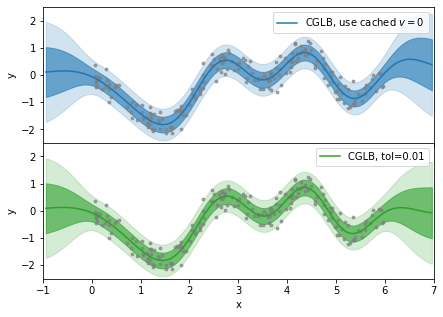

In [8]:
k = 100
xnew = np.linspace(x.min() - 1.0, x.max() + 1.0, k).reshape(-1, 1)

pred_no_tol = cglb.predict_y(xnew, cg_tolerance=None)
pred_tol = cglb.predict_y(xnew, cg_tolerance=0.01)

fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fig.subplots_adjust(hspace=0.0)

x, y = x.squeeze(), y.squeeze()
xnew = xnew.squeeze()

mu_no_tol = pred_no_tol[0].numpy().squeeze()
std_no_tol = np.sqrt(pred_no_tol[1].numpy().squeeze())
plot_prediction(axes[0], x, y, xnew, mu_no_tol, std_no_tol, "tab:blue", "CGLB, use cached $v=0$")


mu_tol = pred_tol[0].numpy().squeeze()
std_tol = np.sqrt(pred_tol[1].numpy().squeeze())
plot_prediction(axes[1], x, y, xnew, mu_tol, std_tol, "tab:green", "CGLB, tol=0.01")

axes[0].legend()
axes[1].legend()
axes[0].set_xlim([-1, 7])
axes[1].set_xlim([-1, 7])
axes[0].set_ylim([-2.5, 2.5])
axes[1].set_ylim([-2.5, 2.5])
axes[0].set_ylabel("y")
axes[1].set_ylabel("y")
axes[1].set_xlabel("x")
plt.show()